<a href="https://colab.research.google.com/github/YouCanKeepSilence/ml_labs/blob/master/ML_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт данных

In [0]:
import numpy as np
import pandas as pd

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Загружаем данные из .csv

In [0]:
names_array = ['gender', 'age', 'first_label', 'second_label', 'third_label', *['c_{}'.format(i + 1) for i in range(60000)]]
url = '/content/drive/My Drive/ML/half.csv'
data = pd.read_csv(url, names=names_array)

# Обработка данных

Удаляем ненужные стобцы (по причине малого количества данных в них)

In [0]:
data = data.drop(['second_label', 'third_label'], axis=1)

In [29]:
#new_data = data # to skip augmentation because it'll break PCA method
#new_batch = 5000
#sensors_count = 12
data

,gender,age,first_label,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31,c_32,c_33,c_34,c_35,c_36,c_37,...,c_59961,c_59962,c_59963,c_59964,c_59965,c_59966,c_59967,c_59968,c_59969,c_59970,c_59971,c_59972,c_59973,c_59974,c_59975,c_59976,c_59977,c_59978,c_59979,c_59980,c_59981,c_59982,c_59983,c_59984,c_59985,c_59986,c_59987,c_59988,c_59989,c_59990,c_59991,c_59992,c_59993,c_59994,c_59995,c_59996,c_59997,c_59998,c_59999,c_60000
0,Female,85,3,0.003242,0.012132,0.022637,0.010953,-0.024891,-0.032752,-0.031432,-0.042890,-0.048659,-0.037955,-0.026816,-0.017216,-0.014815,-0.024370,-0.027953,-0.037105,-0.046662,-0.052641,-0.054785,-0.054178,-0.034856,-0.023726,-0.036748,-0.031842,-0.021913,-0.038332,-0.045422,-0.044497,-0.042550,-0.038772,-0.043089,-0.055117,-0.062105,-0.062300,-0.062635,-0.068795,-0.070163,...,-0.026842,-0.028914,-0.028548,-0.029272,-0.031896,-0.036031,-0.039794,-0.033593,-0.028113,-0.031301,-0.041995,-0.045999,-0.043968,-0.039291,-0.030942,-0.031698,-0.030754,-0.033479,-0.033446,-0.036413,-0.038551,-0.035920,-0.036477,-0.036518,-0.041184,-0.039042,-0.033992,-0.033940,-0.031528,-0.026267,-0.028246,-0.028318,-0.025569,-0.021279,-0.018593,-0.032023,-0.046202,-0.042003,-0.034466,-0.039000
1,Male,79,9,0.012054,0.017017,0.015951,0.020941,0.020960,0.021158,0.021051,0.021062,0.021122,0.021278,0.026533,0.026235,0.016037,0.013366,0.013222,0.008356,0.005556,0.007938,0.008593,0.008398,0.008547,0.008369,0.008677,0.006235,0.000651,-0.001857,-0.001712,-0.007047,-0.009004,-0.012014,-0.019256,-0.019027,-0.019518,-0.018919,-0.020128,-0.021534,-0.024676,...,-0.934049,-0.949376,-0.962051,-0.963686,-0.961742,-0.952030,-0.939060,-0.934415,-0.936366,-0.939326,-0.932011,-0.926725,-0.928331,-0.929013,-0.921389,-0.906309,-0.900787,-0.901273,-0.895911,-0.893740,-0.891627,-0.885869,-0.881577,-0.873489,-0.866113,-0.865862,-0.859139,-0.852907,-0.843380,-0.833925,-0.833698,-0.836701,-0.827418,-0.827810,-0.816231,-0.819793,-0.797862,-0.819597,-0.771195,-0.845490
2,Male,66,3,-0.009508,-0.008508,-0.009508,-0.008508,-0.007508,-0.006508,-0.006508,-0.006508,-0.005508,-0.006508,-0.005508,-0.004508,-0.003508,-0.004508,-0.004508,-0.004508,-0.005508,-0.004508,-0.003508,-0.004508,-0.003508,-0.002508,-0.000508,-0.001508,-0.000508,-0.000508,-0.001508,-0.001508,-0.001508,-0.000508,0.000492,0.002492,0.005492,0.006492,0.007492,0.008492,0.008492,...,-0.051053,-0.052053,-0.051053,-0.049053,-0.047053,-0.044053,-0.040053,-0.037053,-0.036053,-0.034053,-0.034053,-0.034053,-0.033053,-0.031053,-0.028053,-0.025053,-0.022053,-0.019053,-0.017053,-0.017053,-0.016053,-0.016053,-0.014053,-0.013053,-0.010053,-0.007053,-0.003053,0.001947,0.004947,0.007947,0.009947,0.011947,0.012947,0.015947,0.018947,0.023947,0.027947,0.030947,0.034947,0.037947
3,Male,93,2,-0.002271,0.004177,-0.002077,-0.005875,-0.004685,-0.008117,-0.019722,-0.036185,-0.037616,-0.025323,-0.023199,-0.035744,-0.043484,-0.030469,-0.022611,-0.010540,0.004805,0.020337,0.029668,0.017382,0.004737,0.002755,0.014075,0.015677,0.002024,-0.002544,0.000068,0.000271,0.011654,0.022805,0.028631,0.029834,0.030584,0.035327,0.051485,0.059849,0.036704,...,-0.117502,-0.208445,-0.254530,-0.270954,-0.254278,-0.223832,-0.205055,-0.179093,-0.157585,-0.127692,-0.089728,-0.074150,-0.056856,-0.038932,-0.024184,-0.016817,-0.014031,-0.011765,-0.022771,-0.023586,-0.013769,-0.004949,-0.003625,-0.013567,-0.019471,-0.015372,-0.021787,-0.028885,-0.028997,-0.021737,-0.013160,-0.006182,-0.003825,-0.002177,-0.001466,-0.006676,-0.011236,-0.016540,-0.016289,-0.022542
4,Male,65,2,-0.030600,-0.027425,-0.013923,-0.023743,-0.024572,-0.036078,-0.034740,-0.013670,-0.009571,-0.022441,-0.033034,-0.032663,-0.018181,-0.017317,-0.030576,-0.032829,-0.010305,0.005287,0.006696,-0.002352,-0.005559,-0.005361,-0.008254,0.002175,0.007531,0.002662,0.000376,-0.007697,-0.016977,-0.009894,-0.000388,-0.012127,-0.007840,-0.002470,-0.005233,0.004789,-0.007276,...,1.016910,0.710028,0.4

## Агументация данных

In [30]:
# batch_size = 1000
measurment_names = data.columns[3:]
new_data = pd.DataFrame()
# Пользуемся тем, что имеем 5к измерений для каждого из 12 датчиков. Соответственно нарежем по 250 с каждого из 12 датчиков
new_batch = 250
measurments_for_sensors = 5000
sensors_count = 12
for i in range(0, measurments_for_sensors, new_batch):
    current_measurment_names = {f'c_{k + j * measurments_for_sensors + 1}': f'c_{(new_batch * j + k % new_batch) % (new_batch * sensors_count)  + 1}' for j in range(sensors_count) for k in range(i, i + new_batch)}
    mapped_piece = data[['age', 'gender', 'first_label', *[f'c_{k + j * measurments_for_sensors + 1}'  for j in range(sensors_count) for k in range(i, i + new_batch)]]].rename(columns=current_measurment_names)
    new_data = pd.concat([new_data, mapped_piece])


new_data

,age,gender,first_label,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31,c_32,c_33,c_34,c_35,c_36,c_37,...,c_2961,c_2962,c_2963,c_2964,c_2965,c_2966,c_2967,c_2968,c_2969,c_2970,c_2971,c_2972,c_2973,c_2974,c_2975,c_2976,c_2977,c_2978,c_2979,c_2980,c_2981,c_2982,c_2983,c_2984,c_2985,c_2986,c_2987,c_2988,c_2989,c_2990,c_2991,c_2992,c_2993,c_2994,c_2995,c_2996,c_2997,c_2998,c_2999,c_3000
0,85,Female,3,0.003242,0.012132,0.022637,0.010953,-0.024891,-0.032752,-0.031432,-0.042890,-0.048659,-0.037955,-0.026816,-0.017216,-0.014815,-0.024370,-0.027953,-0.037105,-0.046662,-0.052641,-0.054785,-0.054178,-0.034856,-0.023726,-0.036748,-0.031842,-0.021913,-0.038332,-0.045422,-0.044497,-0.042550,-0.038772,-0.043089,-0.055117,-0.062105,-0.062300,-0.062635,-0.068795,-0.070163,...,-0.042165,-0.038295,-0.031430,-0.030939,-0.026489,-0.026416,-0.023869,-0.018956,-0.018332,-0.012197,-0.010827,-0.010946,-0.005748,-0.003529,-0.001014,0.008721,0.006861,0.008915,0.013527,0.016897,0.026238,0.032369,0.039158,0.039443,0.046263,0.052320,0.061813,0.064635,0.064673,0.064160,0.076964,0.099699,0.109083,0.115720,0.124500,0.135699,0.142533,0.157333,0.168144,0.167612
1,79,Male,9,0.012054,0.017017,0.015951,0.020941,0.020960,0.021158,0.021051,0.021062,0.021122,0.021278,0.026533,0.026235,0.016037,0.013366,0.013222,0.008356,0.005556,0.007938,0.008593,0.008398,0.008547,0.008369,0.008677,0.006235,0.000651,-0.001857,-0.001712,-0.007047,-0.009004,-0.012014,-0.019256,-0.019027,-0.019518,-0.018919,-0.020128,-0.021534,-0.024676,...,0.212629,0.212099,0.207610,0.202372,0.197213,0.187022,0.179713,0.174762,0.177674,0.184897,0.191746,0.197086,0.198039,0.200046,0.200121,0.197289,0.187370,0.175233,0.158778,0.142246,0.132504,0.133914,0.141448,0.147200,0.149907,0.149108,0.151819,0.149426,0.139453,0.129564,0.126670,0.126786,0.128829,0.129041,0.124646,0.116546,0.101771,0.086233,0.073918,0.061897
2,66,Male,3,-0.009508,-0.008508,-0.009508,-0.008508,-0.007508,-0.006508,-0.006508,-0.006508,-0.005508,-0.006508,-0.005508,-0.004508,-0.003508,-0.004508,-0.004508,-0.004508,-0.005508,-0.004508,-0.003508,-0.004508,-0.003508,-0.002508,-0.000508,-0.001508,-0.000508,-0.000508,-0.001508,-0.001508,-0.001508,-0.000508,0.000492,0.002492,0.005492,0.006492,0.007492,0.008492,0.008492,...,-0.016053,-0.017053,-0.020053,-0.022053,-0.023053,-0.024053,-0.024053,-0.023053,-0.023053,-0.023053,-0.024053,-0.025053,-0.028053,-0.030053,-0.032053,-0.032053,-0.032053,-0.031053,-0.029053,-0.028053,-0.027053,-0.028053,-0.028053,-0.028053,-0.028053,-0.028053,-0.027053,-0.026053,-0.025053,-0.024053,-0.024053,-0.025053,-0.027053,-0.029053,-0.030053,-0.031053,-0.032053,-0.032053,-0.032053,-0.032053
3,93,Male,2,-0.002271,0.004177,-0.002077,-0.005875,-0.004685,-0.008117,-0.019722,-0.036185,-0.037616,-0.025323,-0.023199,-0.035744,-0.043484,-0.030469,-0.022611,-0.010540,0.004805,0.020337,0.029668,0.017382,0.004737,0.002755,0.014075,0.015677,0.002024,-0.002544,0.000068,0.000271,0.011654,0.022805,0.028631,0.029834,0.030584,0.035327,0.051485,0.059849,0.036704,...,1.231641,1.184278,0.984192,0.756997,0.542910,0.319415,0.119338,-0.071326,-0.200446,-0.274568,-0.318679,-0.322228,-0.294194,-0.261829,-0.233143,-0.208244,-0.184876,-0.160516,-0.140754,-0.124244,-0.121719,-0.111981,-0.094989,-0.074455,-0.061890,-0.059022,-0.059572,-0.059001,-0.061746,-0.067160,-0.077408,-0.082138,-0.076787,-0.072755,-0.077115,-0.079757,-0.079575,-0.077995,-0.083645,-0.090060
4,65,Male,2,-0.030600,-0.027425,-0.013923,-0.023743,-0.024572,-0.036078,-0.034740,-0.013670,-0.009571,-0.022441,-0.033034,-0.032663,-0.018181,-0.017317,-0.030576,-0.032829,-0.010305,0.005287,0.006696,-0.002352,-0.005559,-0.005361,-0.008254,0.002175,0.007531,0.002662,0.000376,-0.007697,-0.016977,-0.009894,-0.000388,-0.012127,-0.007840,-0.002470,-0.005233,0.004789,-0.007276,...,-0.064945,-0.069677,-0.072775,-0.069443,-0.067366,-0.071764,-0.072349,-0.071588,-0.067871,-0.064693,-0.059544,-0.056611,

Таким образом получаем из размерности 1250, 60003 -> 25000, 3003 увеличив количество записей в датасете в 20 раз



## Обработаем пропущенные значения

In [31]:
print(new_data['age'].unique())
print(new_data['gender'].unique())
print(new_data['first_label'].unique())
print(new_data.isnull().sum())

[85 79 66 93 65 55 82 87 51 61 90 77 70 60 62 59 84 71 45 48 75 49 72 78
 86 46 94 33 74 64 67 63 88 32 92 68 76 54 89 31 80 30 57 83 34 27 73 69
 52 44 43 47 39 56 81 53 50 16 29 37 58 24 22 40 41 11 26 28 96 35 91 25
 36 23 19 17 42 18 15  8 20 38 14 21]
['Female' 'Male']
[3 9 2 5 1 7 6 4 8]
age            0
gender         0
first_label    0
c_1            0
c_2            0
              ..
c_2996         0
c_2997         0
c_2998         0
c_2999         0
c_3000         0
Length: 3003, dtype: int64


Пропущенных значений нет.

## Обработаем категориальные признаки

In [32]:
categorial_columns = ['gender', 'first_label']
numerical_columns = ['age', *[f'c_{i + 1}' for i in range(new_batch * sensors_count)]]
print(categorial_columns)

['gender', 'first_label']


Проведем бинаризацию пола, label не трогаем, им займемся дальше

In [33]:
new_data.at[data['gender'] == 'Male', 'gender'] = 0
new_data.at[data['gender'] == 'Female', 'gender'] = 1
new_data['gender'].describe()

count    25000.000000
mean         0.392800
std          0.488383
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: gender, dtype: float64

In [0]:
categorial_columns.remove('gender')
numerical_columns.append('gender')

## Произведем нормировку данных

In [35]:
numerical_data = new_data[numerical_columns]
numerical_data.describe()

,age,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31,c_32,c_33,c_34,c_35,c_36,c_37,c_38,c_39,...,c_2962,c_2963,c_2964,c_2965,c_2966,c_2967,c_2968,c_2969,c_2970,c_2971,c_2972,c_2973,c_2974,c_2975,c_2976,c_2977,c_2978,c_2979,c_2980,c_2981,c_2982,c_2983,c_2984,c_2985,c_2986,c_2987,c_2988,c_2989,c_2990,c_2991,c_2992,c_2993,c_2994,c_2995,c_2996,c_2997,c_2998,c_2999,c_3000,gender
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,...,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,65.856000,0.000762,0.000802,0.000810,0.000940,0.001033,0.000924,0.000781,0.000777,0.000753,0.000530,0.000368,0.000346,0.000373,0.000399,0.000486,0.000694,0.000880,0.000917,0.000873,0.000832,0.000801,0.000906,0.000994,0.001168,0.001379,0.001349,0.001266,0.001394,0.001425,0.001405,0.001417,0.001554,0.001832,0.002145,0.002207,0.001945,0.001740,0.001737,0.001706,...,0.001751,0.001973,0.002174,0.002476,0.002612,0.002480,0.002445,0.002425,0.002151,0.001732,0.001278,0.000694,0.000215,-0.000170,-0.000603,-0.001044,-0.000008,-0.001462,-0.001502,-0.001314,-0.001029,-0.000851,-0.000691,-0.000384,-0.000259,-0.000393,-0.000551,-0.000489,-0.000360,-0.000219,-0.000064,-0.000224,-0.000559,-0.000782,-0.001042,-0.001300,-0.001426,-0.001226,-0.001046,0.392800
std,16.253524,0.136387,0.137773,0.137118,0.137196,0.137183,0.138046,0.138676,0.138399,0.137578,0.137019,0.137186,0.137764,0.138111,0.138181,0.138472,0.138996,0.139592,0.139737,0.139221,0.138856,0.138605,0.138345,0.138173,0.137900,0.137880,0.138138,0.138804,0.139353,0.139560,0.139626,0.139884,0.140227,0.140575,0.140480,0.140464,0.140714,0.140830,0.140509,0.140031,...,0.310643,0.311782,0.312683,0.313296,0.313791,0.313975,0.313725,0.313292,0.313184,0.312811,0.311326,0.309553,0.307481,0.304950,0.302414,0.300869,0.364148,0.298560,0.299325,0.300936,0.302068,0.303145,0.303709,0.302365,0.301408,0.300944,0.300971,0.301375,0.302341,0.302910,0.301874,0.300346,0.298497,0.296093,0.293834,0.292313,0.290933,0.288951,0.290090,0.488383
min,8.000000,-2.098990,-2.084990,-2.072990,-2.059990,-2.048990,-2.043990,-2.040990,-2.034990,-2.021990,-1.993990,-1.957990,-1.921990,-1.888990,-1.867990,-1.854990,-1.843990,-1.830990,-1.811990,-1.784990,-1.748990,-1.710990,-1.670990,-1.634990,-1.599990,-1.560990,-1.550966,-1.541831,-1.540635,-1.514305,-1.533516,-1.519430,-1.500173,-1.491844,-1.507423,-1.550061,-1.609154,-1.643169,-1.651291,-1.647740,...,-5.200125,-5.189448,-5.187218,-5.188839,-5.203222,-5.211987,-5.228917,-5.223156,-5.240069,-5.024664,-5.023922,-5.024141,-5.024023,-5.025422,-5.025206,-5.025006,-5.026553,-5.022916,-5.029708,-5.018887,-5.033528,-5.024271,-4.939914,-4.778555,-4.736596,-4.713025,-4.717025,-4.721025,-4.725025,-4.730025,-4.736025,-4.740025,-4.750920,-4.751406,-4.736596,-4.713025,-4.702025,-4.690025,-4.676025,0.000000
25%,58.000000,-0.043578,-0.044326,-0.044179,-0.043680,-0.043411,-0.043684,-0.044073,-0.043883,-0.043947,-0.043866,-0.043805,-0.043748,-0.043690,-0.044026,-0.044191,-0.043996,-0.043920,

In [0]:
mean = numerical_data.mean(axis = 0)
std = numerical_data.std(axis = 0)
numerical_data = (numerical_data - mean) / std
new_data[numerical_columns] = numerical_data

In [37]:
new_data.describe()

,age,gender,first_label,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,c_29,c_30,c_31,c_32,c_33,c_34,c_35,c_36,c_37,...,c_2961,c_2962,c_2963,c_2964,c_2965,c_2966,c_2967,c_2968,c_2969,c_2970,c_2971,c_2972,c_2973,c_2974,c_2975,c_2976,c_2977,c_2978,c_2979,c_2980,c_2981,c_2982,c_2983,c_2984,c_2985,c_2986,c_2987,c_2988,c_2989,c_2990,c_2991,c_2992,c_2993,c_2994,c_2995,c_2996,c_2997,c_2998,c_2999,c_3000
count,2.500000e+04,2.500000e+04,25000.000000,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,...,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04,2.500000e+04
mean,3.352074e-16,-6.536993e-17,4.007200,2.841949e-17,4.110157e-17,2.992051e-17,1.389222e-17,3.139711e-18,-5.066170e-17,-6.586771e-17,-1.635192e-17,-1.610934e-17,-3.673617e-17,5.384915e-17,-4.832135e-17,-2.791434e-17,-1.739719e-17,-4.973799e-17,5.285550e-17,1.312950e-17,1.526579e-16,3.822609e-17,8.634760e-19,1.974643e-17,-1.333228e-16,-7.420148e-17,-7.246426e-18,3.073097e-17,6.470824e-17,2.856604e-17,8.425538e-17,4.201361e-17,3.455458e-17,2.840839e-17,-3.054890e-17,4.133249e-17,2.704309e-17,8.126277e-18,1.971978e-17,4.654610e-17,...,4.215850e-17,5.924150e-18,2.241540e-18,-2.288281e-17,-2.489675e-17,-1.692979e-17,-8.574252e-18,9.707790e-18,1.172618e-17,-2.219336e-17,4.615863e-17,-2.820744e-17,3.903544e-18,6.528111e-18,-1.302514e-17,1.854294e-17,-7.949197e-18,4.972689e-18,9.917622e-18,-3.222977e-18,3.162803e-17,-6.568079e-18,-1.882050e-17,-5.194067e-17,8.597567e-18,1.087130e-17,-3.446132e-17,-1.527667e-17,-2.167155e-18,1.517009e-17,2.128075e-17,-1.151079e-17,-4.618528e-19,-3.911538e-17,-2.497558e-17,2.058798e-17,-1.215916e-17,-1.763811e-17,4.416467e-17,1.271871e-17
std,1.000000e+00,1.000000e+00,2.206024,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.559597e+00,-8.042872e-01,1.000000,-1.539551e+01,-1.513936e+01,-1.512419e+01,-1.502177e+01,-1.494375e+01,-1.481324e+01,-1.472330e+01,-1.470938e+01,-1.470249e+01,-1.455654e+01,-1.427525e+01,-1.395386e+01,-1.368003e+01,-1.352133e+01,-1.339969e+01,-1.327146e+01,-1.312303e+01,-1.297373e+01,-1.282757e+01,-1.260166e+01,-1.235017e+01,-1.2084

Нормализовали все поля кроме label т.к. он является выходным и его нет смысла нормализовывать.

# Подготовка данных для модели

In [38]:
from sklearn.model_selection import train_test_split
y = new_data['first_label'].values
X = new_data.drop(['first_label'], axis=1).values

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

n_train, _ = x_train.shape 
n_test,  _ = x_test.shape 

print('Train dataset size: {}'.format(n_train))
print('Test dataset size: {}'.format(n_test))

Train dataset size: 17500
Test dataset size: 7500


# Создание и обучение моделей

## Random Forest

In [0]:
from sklearn import ensemble
to_plot = []
estimators = [30, 50, 100, 300, 500, 1000]
for n_est in estimators:
  rf_model = ensemble.RandomForestClassifier(n_estimators=n_est, oob_score=True)
  rf_model.fit(x_train, y_train)
  err_train = np.mean(rf_model.predict(x_train) != y_train)
  err_test  = np.mean(rf_model.predict(x_test) != y_test)
  err_oob = rf_model.oob_score_
  to_plot.append({
      'n': n_est,
      'train': err_train,
      'test': err_test,
      'oob': err_oob
  })
  print(err_train, err_test, err_oob)

In [40]:
# Debug (result of previous trains)
to_plot = [{'n': 30,
  'oob': 0.458,
  'test': 0.4886666666666667,
  'train': 0.011485714285714285},
 {'n': 50,
  'oob': 0.4897714285714286,
  'test': 0.46186666666666665,
  'train': 0.011542857142857143},
 {'n': 100,
  'oob': 0.5242857142857142,
  'test': 0.4524,
  'train': 0.011485714285714285},
 {'n': 300,
  'oob': 0.5444,
  'test': 0.44693333333333335,
  'train': 0.011485714285714285},
 {'n': 500,
  'oob': 0.5517142857142857,
  'test': 0.4416,
  'train': 0.011485714285714285},
 {'n': 1000,
  'oob': 0.5564571428571429,
  'test': 0.43893333333333334,
  'train': 0.011485714285714285}]
to_plot


[{'n': 30,
  'oob': 0.458,
  'test': 0.4886666666666667,
  'train': 0.011485714285714285},
 {'n': 50,
  'oob': 0.4897714285714286,
  'test': 0.46186666666666665,
  'train': 0.011542857142857143},
 {'n': 100,
  'oob': 0.5242857142857142,
  'test': 0.4524,
  'train': 0.011485714285714285},
 {'n': 300,
  'oob': 0.5444,
  'test': 0.44693333333333335,
  'train': 0.011485714285714285},
 {'n': 500,
  'oob': 0.5517142857142857,
  'test': 0.4416,
  'train': 0.011485714285714285},
 {'n': 1000,
  'oob': 0.5564571428571429,
  'test': 0.43893333333333334,
  'train': 0.011485714285714285}]

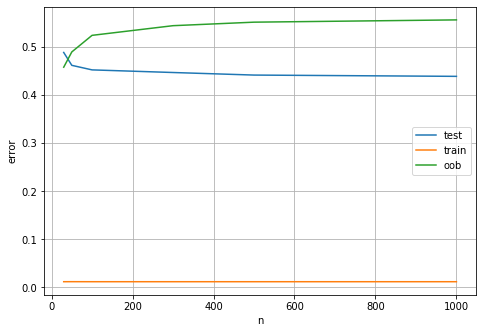

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure()
axes = fig.add_axes([1, 1, 1, 1])
axes.set_xlabel('n')
axes.set_ylabel('error')
axes.plot(list(map(lambda x: x['n'], to_plot)), list(map(lambda x: x['test'], to_plot)), label='test')
axes.plot(list(map(lambda x: x['n'], to_plot)), list(map(lambda x: x['train'], to_plot)), label='train')
axes.plot(list(map(lambda x: x['n'], to_plot)), list(map(lambda x: x['oob'], to_plot)), label='oob')
axes.legend()
axes.grid()

### Результат
Заметно переобучение, однако, разрыв между ошибкой на тестовой выборке и на тренировочной снижается с ростом кол-ва деревьев. Наибольшая точность достигается при 1000 деревьях. В таком случае ошибка составляет около 44%, что меньше (на 5-10%) чем у других методов, но сильно смущает разрыв между тестовой и тренировочной выборкой, возможно стоит попробовать еще более увеличить кол-во деревьев, что однако, требует большого количества времени

## Gradient Boosted Trees

In [0]:
to_plot_gb = []
estimators = [30]
for n_est in estimators:
  gbt_model = ensemble.GradientBoostingClassifier(n_estimators=n_est)
  gbt_model.fit(x_train, y_train)
  err_train = np.mean(gbt_model.predict(x_train) != y_train)
  err_test  = np.mean(gbt_model.predict(x_test) != y_test)
  to_plot_gb.append({
      'n': n_est,
      'train': err_train,
      'test': err_test,
      # 'oob': err_oob
  })
  print(err_train, err_test)
  # started at 13:21

In [0]:
to_plot_gb

# Вывод
С точки зрения точности модели метод Random Forest показал наилучшие результаты (56%), что немного лучше остальных методов, однако, заметно сильное переобучение. Дождаться результатов обучения Gradient Boosted Trees не удалось. Оптимальным с точки зрения сочетаний точности и отсутствия переобучения мне показался метод с использованием полносвязной нейросети без использования РСА. Он хоть и дает чуть меньше точности чем Random Forest, но зато в нем практически не наблюдается переобучения. Возможно, иная структура сети смогла бы показать более хороший результат.